# Lung Cancer Detection using Convolutional Neural Network (CNN)

Computer Vision is one of the applications of deep neural networks that enables us to automate tasks that earlier required years of expertise and one such use in predicting the presence of cancerous cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
from zipfile import ZipFile
 
data_path = 'lung-and-colon-cancer-histopathological-images.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


### Data Visualization

In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

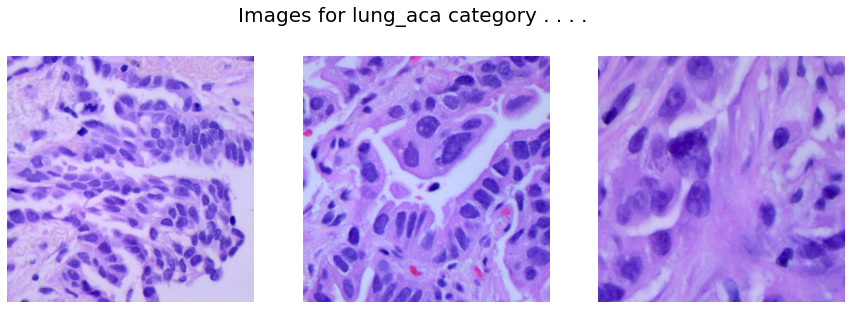

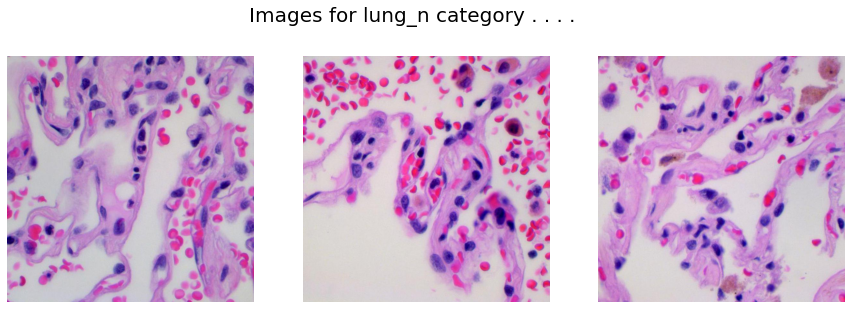

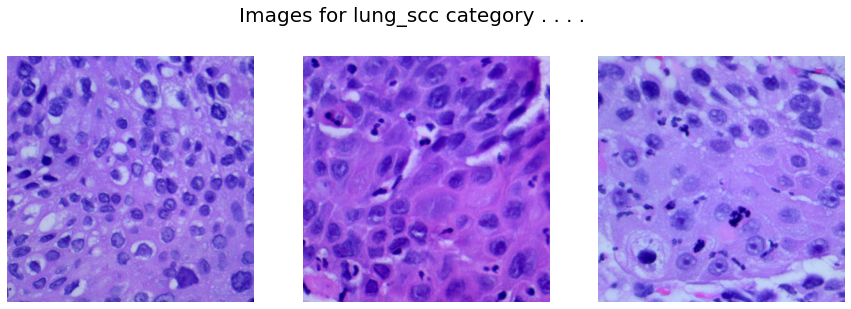

In [4]:
path = 'lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

### Data Preparation for Training

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [6]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


### Model Development

In [8]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [12]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 415s 2s/step - loss: 0.3521 - accuracy: 0.8553 - val_loss: 2.8740 - val_accuracy: 0.3853 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 425s 2s/step - loss: 0.2157 - accuracy: 0.9143 - val_loss: 34.1312 - val_accuracy: 0.4120 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9384
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 431s 2s/step - loss: 0.1565 - accuracy: 0.9384 - val_loss: 6.0958 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 424s 2s/step - loss: 0.1111 - accuracy: 0.9593 - val_loss: 3.8956 - val_accuracy: 0.6590 - lr: 5.0000e-04
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9711
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
188/188 [=============================

Let’s visualize the training and validation accuracy with each epoch.

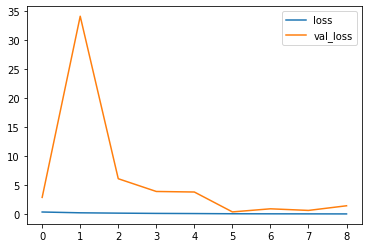

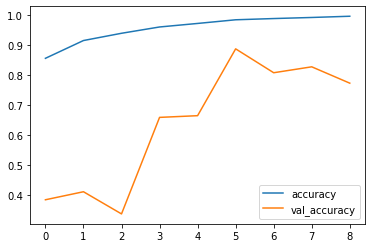

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

### Model Evaluation

In [14]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 19s 204ms/step


Let’s draw the confusion metrics and classification report using the predicted labels and the true labels.

In [15]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 680,    8,  299],
       [  16,  961,    0],
       [  17,    0, 1019]], dtype=int64)

In [16]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.95      0.69      0.80       987
      lung_n       0.99      0.98      0.99       977
    lung_scc       0.77      0.98      0.87      1036

    accuracy                           0.89      3000
   macro avg       0.91      0.89      0.88      3000
weighted avg       0.90      0.89      0.88      3000

